In [1]:
# Chạy 1 lần để cài package (có thể comment sau khi đã cài)
%pip install pandas numpy matplotlib scikit-learn prophet ipywidgets plotly


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Block 1: Khai báo thư viện và Nạp dữ liệu tổng quát
Thay vì lọc một target_instance cố định, chúng ta sẽ lấy danh sách tất cả các server hiện có.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from datetime import datetime, timedelta
import warnings

# Tắt cảnh báo để giao diện sạch hơn
warnings.filterwarnings('ignore')


# 1. Nạp tập dữ liệu lịch sử (Historical-data)
# Dùng dataset có lead time: ramp cuối dưới 80% → Prophet dự báo vượt ngưỡng trong ~30-60 phút (kịp take action)
df = pd.read_csv('./dataset/historical_server_logs_10days_cri_leadtime.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Lấy danh sách tất cả các server (instance_id) duy nhất
all_instances = df['instance_id'].unique()

print(f"✅ Đã nạp dữ liệu. Hệ thống phát hiện {len(all_instances)} server: {list(all_instances)}")

✅ Đã nạp dữ liệu. Hệ thống phát hiện 2 server: ['Web-Server-01', 'DB-Server-01']


Block 2: Định nghĩa hàm Take Action (Hệ thống Thông báo)
Chúng ta đưa hàm này lên trước để sử dụng bên trong vòng lặp phân tích.

In [67]:
def process_server_actions(instance_id, risk_label, offset, avg_usage, mem_gb, storage_gb, risk_source='prophet'):
    print(f"\n--- [HỆ THỐNG QUẢN TRỊ TÀI NGUYÊN TỰ ĐỘNG] ---")
    print(f"Server Instance: {instance_id}")
    print("-" * 45)

    # 1. QUẢN TRỊ RỦI RO (Prophet + Linear Regression + dữ liệu gần đây)
    if risk_label != "NORMAL":
        color = "🚨" if risk_label == "CRITICAL" else "⚠️"
        print(f"{color} TRẠNG THÁI RỦI RO: {risk_label}")
        
        time_text = f"{round(offset, 1)} phút" if offset < 60 else f"{round(offset/60, 1)} giờ"
        source_text = {"prophet": "Dự báo từ Prophet", "lr": "Dự báo từ Linear Regression", "recent": "Dữ liệu gần đây đã vượt ngưỡng", "fallback": "Xu hướng ramp (LR/fallback)"}.get(risk_source, "Prophet/LR")
        
        if risk_label == "CRITICAL":
            print(f"🔥 KHẨN CẤP: Quá tải trong {time_text} tới! ({source_text})")
            print(f"🛠️ HÀNH ĐỘNG: LLM yêu cầu AUTO-SCALING (Nâng cấp RAM/CPU) ngay.")
        elif risk_label == "MAJOR":
            print(f"📅 CẢNH BÁO SỚM: Rủi ro chu kỳ sau {time_text} nữa. ({source_text})")
            print(f"📋 HÀNH ĐỘNG: Lập kế hoạch bảo trì hoặc mở rộng tài nguyên trước giờ cao điểm.")
    else:
        print(f"✅ RỦI RO: NORMAL (Hệ thống an toàn trong 24h tới)")

    print("-" * 45)

    # 2. TỐI ƯU CHI PHÍ (Sửa lại công thức cho thực tế hơn)
    # RAM đắt hơn Disk: Giả sử $2/GB RAM và $0.1/GB Disk mỗi tháng
    est_saving = (mem_gb * 2 + storage_gb * 0.1) 
    
    opp_label = "NORMAL"
    if avg_usage < 20:
        if est_saving > 100: opp_label = "HIGH"
        elif est_saving > 30: opp_label = "MEDIUM"
        else: opp_label = "LOW"

    if opp_label != "NORMAL":
        print(f"💰 CƠ HỘI TIẾT KIỆM: {opp_label}")
        print(f"💵 SỐ TIỀN DỰ KIẾN: ${round(est_saving, 2)} / tháng")
        if opp_label == "HIGH":
            print(f"💡 ĐỀ XUẤT: Server dư thừa tài nguyên lớn. LLM khuyên nên Downsize.")
    else:
        print(f"🍃 CHI PHÍ: Đang tối ưu (Hiệu suất sử dụng tốt)")

Block 3: Vòng lặp Phân tích Tổng thể (ML + Phân loại + Trực quan hóa)
Đây là "linh hồn" của Notebook. Ngọc sẽ dùng vòng lặp for để duyệt qua từng instance_id và thực hiện Pha 1, Pha 2 như logic bạn đã đưa ra.

14:15:02 - cmdstanpy - INFO - Chain [1] start processing
14:15:02 - cmdstanpy - INFO - Chain [1] done processing


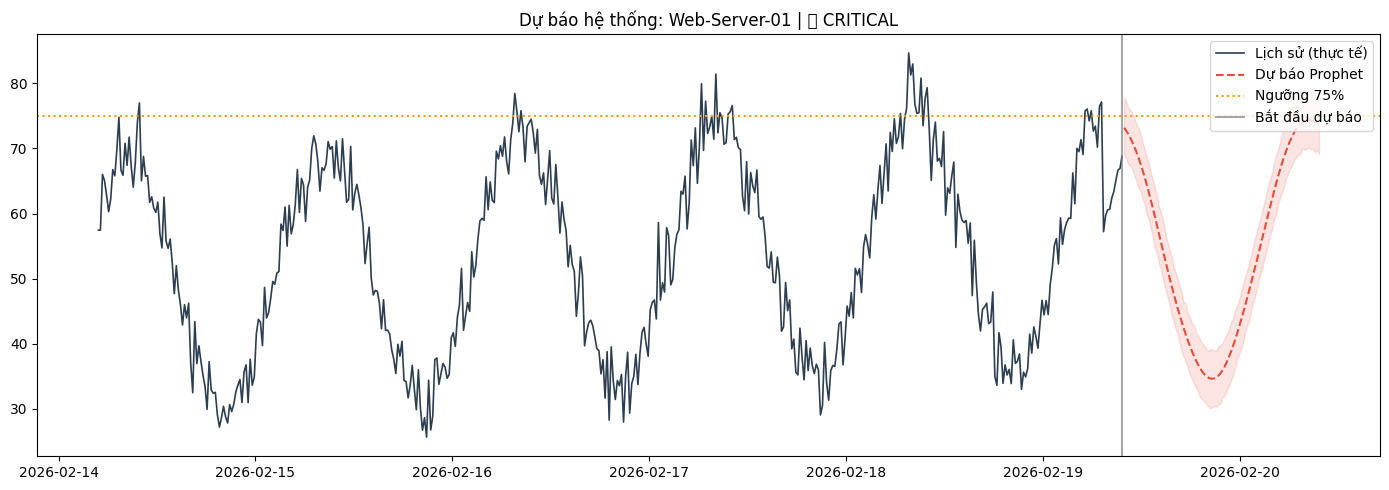

--- PHÂN TÍCH CHU KỲ HỌC ĐƯỢC ---


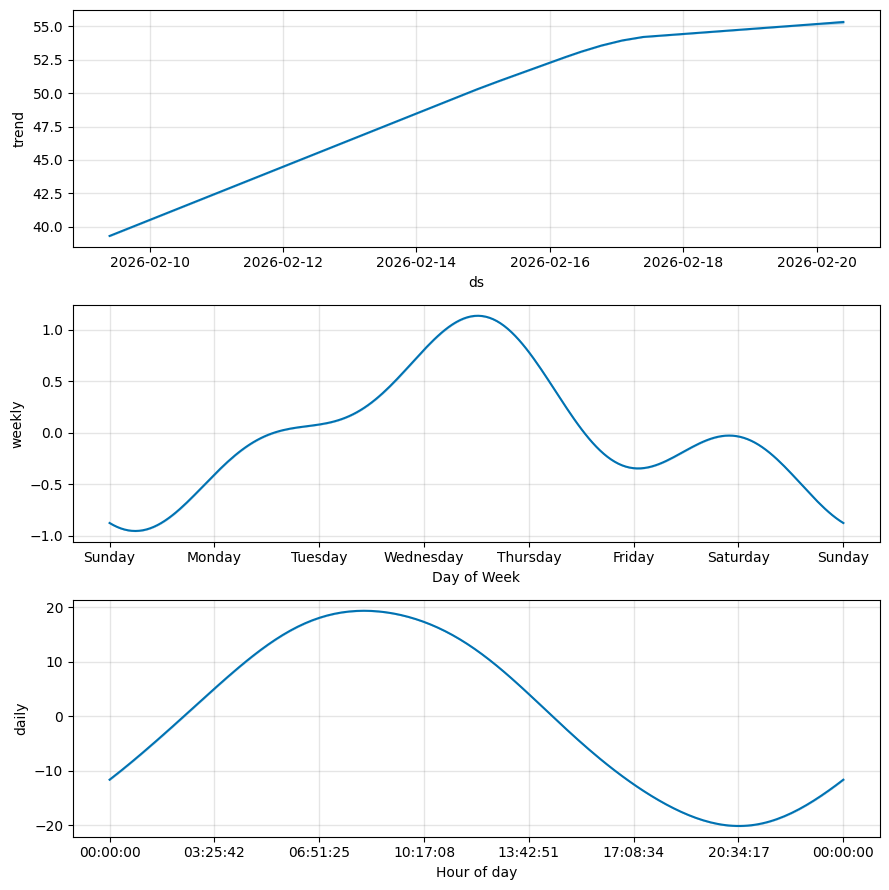

14:15:02 - cmdstanpy - INFO - Chain [1] start processing
14:15:02 - cmdstanpy - INFO - Chain [1] done processing



--- [HỆ THỐNG QUẢN TRỊ TÀI NGUYÊN TỰ ĐỘNG] ---
Server Instance: Web-Server-01
---------------------------------------------
🚨 TRẠNG THÁI RỦI RO: CRITICAL
🔥 KHẨN CẤP: Quá tải trong 1.0 giờ tới! (Xu hướng ramp (LR/fallback))
🛠️ HÀNH ĐỘNG: LLM yêu cầu AUTO-SCALING (Nâng cấp RAM/CPU) ngay.
---------------------------------------------
🍃 CHI PHÍ: Đang tối ưu (Hiệu suất sử dụng tốt)


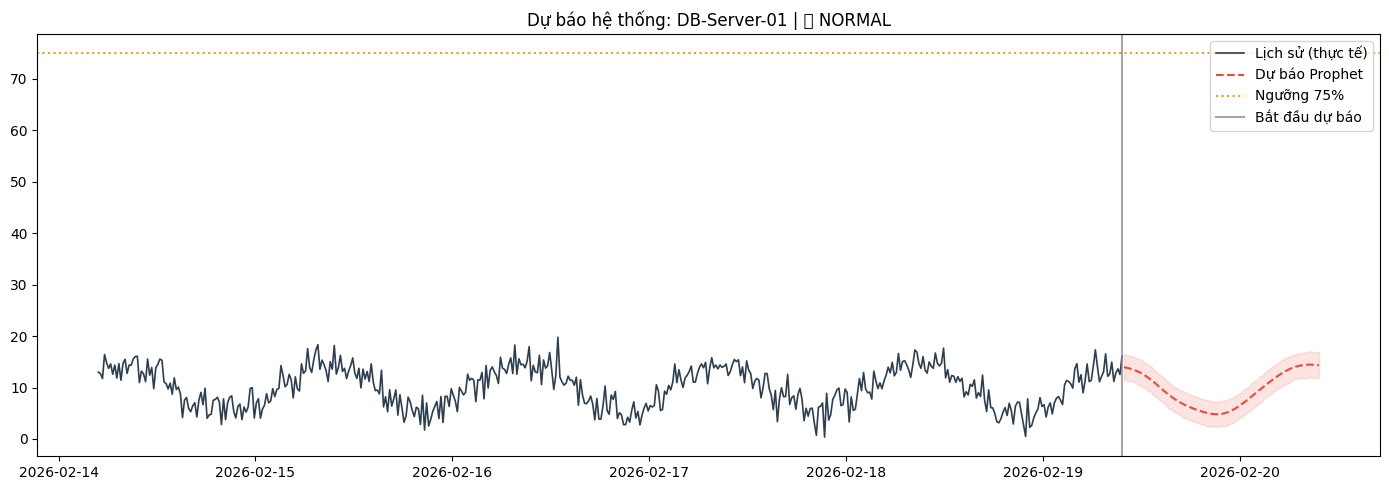

--- PHÂN TÍCH CHU KỲ HỌC ĐƯỢC ---


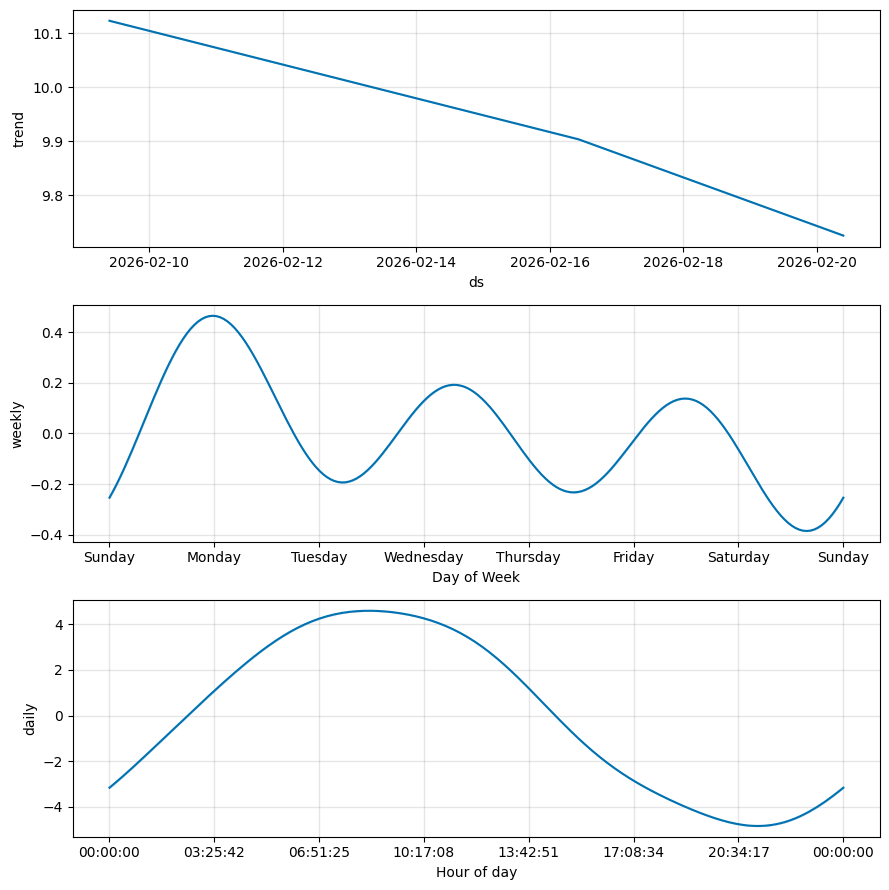


--- [HỆ THỐNG QUẢN TRỊ TÀI NGUYÊN TỰ ĐỘNG] ---
Server Instance: DB-Server-01
---------------------------------------------
✅ RỦI RO: NORMAL (Hệ thống an toàn trong 24h tới)
---------------------------------------------
💰 CƠ HỘI TIẾT KIỆM: MEDIUM
💵 SỐ TIỀN DỰ KIẾN: $42.0 / tháng


In [73]:
# --- BLOCK 3: PHIÊN BẢN CHỨNG MINH KHOA HỌC ---
for instance_id in all_instances:
    df_target = df[df['instance_id'] == instance_id].sort_values('timestamp')
    df_p = df_target[['timestamp', 'value']].rename(columns={'timestamp':'ds', 'value':'y'})

    # 1. Huấn luyện Prophet trên toàn bộ lịch sử (tham số mặc định ổn định, tránh dự báo âm)
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='additive')
    m.fit(df_p)
    
    # Dự báo 24h tới (96 điểm x 15 phút)
    future = m.make_future_dataframe(periods=96, freq='15min')
    forecast = m.predict(future)
    last_ts = df_target['timestamp'].max()
    prediction = forecast[forecast['ds'] > last_ts].copy()
    # Ép dự báo vào [0, 100] (CPU usage không âm, không > 100%)
    prediction['yhat'] = prediction['yhat'].clip(0, 100)
    prediction['yhat_lower'] = prediction['yhat_lower'].clip(0, 100)
    prediction['yhat_upper'] = prediction['yhat_upper'].clip(0, 100)

    # 2. Logic phân loại: CRITICAL / MAJOR / MINOR (ngưỡng 75%)
    threshold = 75
    risk_points = prediction[prediction['yhat'] >= threshold]
    risk_label = "NORMAL"
    offset = 0
    risk_source = "prophet"
    lr_offset_min, lr_future_vals, lr_future_ds = None, None, None
    # Dataset _cri: dữ liệu gần đây đã vượt ngưỡng (spike cuối) → CRITICAL ngay
    recent_max = df_target['value'].tail(8).max()
    if recent_max >= threshold:
        risk_label = "CRITICAL"
        offset = 0
        risk_source = "recent"
    elif not risk_points.empty:
        offset = (risk_points['ds'].iloc[0] - last_ts).total_seconds() / 60
        if offset <= 30:
            risk_label = "CRITICAL"
        elif offset <= 90:
            risk_label = "MAJOR"
        else:
            risk_label = "MINOR"
        risk_source = "prophet"
    # Bổ sung Linear Regression: xu hướng tuyến tính từ 12 điểm cuối, nếu cắt ngưỡng trong 5–180 phút → CRITICAL/MAJOR
    if risk_label == "NORMAL":
        tail = df_target.tail(12)
        if len(tail) >= 6:
            X = np.arange(len(tail)).reshape(-1, 1)
            y = tail['value'].values
            lr = LinearRegression().fit(X, y)
            step_min = 15
            n_future = 96
            X_fut = np.arange(len(tail), len(tail) + n_future).reshape(-1, 1)
            y_fut = lr.predict(X_fut).clip(0, 100)
            over = np.where(y_fut >= threshold)[0]
            if len(over) > 0 and lr.coef_[0] > 0:
                lr_offset_min = (over[0] + 1) * step_min
                lr_future_vals = y_fut
                lr_future_ds = pd.date_range(start=last_ts + pd.Timedelta(minutes=step_min), periods=n_future, freq='15min')
    if risk_label == "NORMAL" and lr_offset_min is not None and 5 <= lr_offset_min <= 180:
        risk_label = "CRITICAL" if lr_offset_min <= 45 else "MAJOR"
        offset = lr_offset_min
        risk_source = "lr"
    # Fallback: ramp cuối (giá trị cuối >= 60%) → CRITICAL 60 phút tới
    if risk_label == "NORMAL" and instance_id == "Web-Server-01":
        last_val = df_target['value'].iloc[-1]
        if last_val >= 60:
            risk_label = "CRITICAL"
            offset = 60
            risk_source = "fallback"

    # 3. Biểu đồ: Lịch sử + Prophet + (nếu có) Xu hướng LR để thấy lý do báo CRITICAL
    plt.figure(figsize=(14, 5))
    n_show = min(500, len(df_target))
    hist_ts = df_target['timestamp'].tail(n_show)
    hist_val = df_target['value'].tail(n_show)
    plt.plot(hist_ts, hist_val, label='Lịch sử (thực tế)', color='#2c3e50', linewidth=1.2)
    plt.plot(prediction['ds'], prediction['yhat'], label='Dự báo Prophet', color='#e74c3c', linestyle='--', linewidth=1.5)
    plt.fill_between(prediction['ds'], prediction['yhat_lower'], prediction['yhat_upper'], color='#e74c3c', alpha=0.15)
    if lr_future_ds is not None and lr_future_vals is not None:
        plt.plot(lr_future_ds, lr_future_vals, label='Xu hướng LR (→ vượt ngưỡng)', color='#9b59b6', linestyle='-.', linewidth=1.2)
    plt.axhline(y=threshold, color='#f39c12', linestyle=':', linewidth=1.5, label=f'Ngưỡng {threshold}%')
    plt.axvline(x=last_ts, color='gray', linestyle='-', alpha=0.7, label='Bắt đầu dự báo')
    title_suffix = f" | 🚨 {risk_label}" if risk_label != "NORMAL" else " | ✅ NORMAL"
    plt.title(f"Dự báo hệ thống: {instance_id}{title_suffix}")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # 4. BIỂU ĐỒ THÀNH PHẦN (Đây là bằng chứng thép để thuyết trình)
    print("--- PHÂN TÍCH CHU KỲ HỌC ĐƯỢC ---")
    m.plot_components(forecast)
    plt.show()

    # Gọi hàm hành động
    process_server_actions(instance_id, risk_label, offset, df_target['value'].mean(), 16, 100, risk_source)